In [1]:
import seaborn as sns
import os
import glob
import pandas as pd
import numpy as np
import librosa
import librosa.display
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from utils import *

In [2]:
genre_mapping = {
    'blues': 0,
    'classical': 1,
    'country': 2,
    'disco': 3,
    'hiphop': 4,
    'jazz': 5,
    'metal': 6,
    'pop': 7,
    'reggae': 8,
    'rock': 9, 
}
DATA_PATH = '../../data/GTZAN'

In [3]:
class GtzanData:
    """
    GTZAN Data generator using data augmentation techniques
    Options (for now):
        - noise-injection: (0, 0.2, step=0.001)
        - pitch-shift: (-5, 5, 0.5)
    """
    def __init__(
        self,
        noise_injection=(0.0, 0.1, 0.02),
        pitch_shift=(-5, 0, 1),
        test_size=0.1,
    ):
        init_x, self.test_x, init_y, self.test_y = train_test_split(df['filePath'],
                                                                df['label'],
                                                                test_size=test_size)
        self.prep_test_values()
        self.init_dataframe(init_x, init_y, noise_injection, pitch_shift)
    
    def __len__(self):
        return len(self.train_y)
    def __getitem__(self, index):
        return self.train_x[index]
    def prep_test_values(self):
        new_test_x = []
        new_test_y = []
        for index, path in self.test_x.iteritems():
            new_test_x.append(create_spectrogram_from_filepath(path))
            new_test_y.append(genre_mapping[str(self.test_y[index])])
        self.test_x = np.array(new_test_x)
        self.test_y = np.array(new_test_y)
        print('Tests created: ', self.test_x.shape, self.test_y.shape)
        print(self.test_x[0])
    def init_dataframe(self, init_x, init_y, noise_injection, pitch_shift):
        self.set_up_buckets(init_x, init_y)

        NOISE_INJECTION_STEPS = ((noise_injection[1] - noise_injection[0]) / noise_injection[2])
        PITCH_SHIFT_STEPS = ((pitch_shift[1] - pitch_shift[0]) / pitch_shift[2])
        NUM_OF_AUGMENTED_DATA = (len(self.train_x)) * (NOISE_INJECTION_STEPS + PITCH_SHIFT_STEPS)
        print('Entering init_dataframe loop')
        
        for index, filePath in tqdm(init_x.iteritems()):
            wave_data, sample_rate = librosa.core.load(filePath, 
                                               sr    = None,
                                               mono  = True,
                                               dtype = np.float32)
            # We have the wave data now lets augment it -> Noise injection first
            self.create_noise_injected_data(wave_data,
                                        sample_rate,
                                        noise_injection,
                                        genre_mapping[str(init_y[index])])
            self.create_pitch_shifted_data(wave_data,
                                        sample_rate,
                                        pitch_shift,
                                        genre_mapping[str(init_y[index])])
        # Now that its done lets turn it all to tensors
        self.train_x = np.array(self.train_x)
        self.train_y = np.array(self.train_y)
        print(self.train_x.shape, self.train_y.shape)
    
    
    def create_noise_injected_data(self, wd, sr, ni, label):
        for noise_factor in np.arange(ni[0] + ni[2], ni[1] + ni[2], ni[2]):
            if noise_factor == 0: continue

            print('noise factor: %f' % (noise_factor))
            noise = np.random.randn(len(wd))
            augmented_data = wd + noise_factor * noise
            self.train_x.append(create_spectrogram(augmented_data.astype(type(wd[0])), sr, 16000))
            self.train_y.append(label)
    def create_pitch_shifted_data(self, wd, sr, ps, label):
        for pitch_factor in np.arange(ps[0], ps[1], ps[2]):
            if pitch_factor == 1: continue

            print('pitch factor: %f' % (pitch_factor))
            augmented_data = librosa.effects.pitch_shift(wd, sr, pitch_factor)
            self.train_x.append(create_spectrogram(augmented_data.astype(type(wd[0])), sr, 16000))
            self.train_y.append(label)
    def set_up_buckets(self, init_x, init_y):
        self.train_x = []
        self.train_y = []
        print('Entering set_up_buckets loop')
        print('num of iterations: %i' % (init_x.size))

        for index, row in tqdm(init_x.iteritems()):
            wave_data, sample_rate = librosa.core.load(row, 
                                               sr    = None,
                                               mono  = True,
                                               dtype = np.float32)
            self.train_x.append(create_spectrogram(wave_data, sample_rate, 16000))
            self.train_y.append(genre_mapping[str(init_y[index])])
        print(len(self.train_x), self.train_y)
        print(self.train_x[0])


In [4]:
class GtzanDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    def __getitem__(self, index):
        if self.transform is not None:
            return (self.transform(self.X[index]), self.y[index]) 
        return (self.X[index], y[index])
    def __len__(self):
        return len(self.X)  


In [5]:
df = getDataFrame(True)

In [7]:
BASE_SAMPLE_RATE = 16000

class GtzanWave:
    """
    GTZAN Data generator using data augmentation techniques
    Only wave data is the output
    Options (for now):
        - noise-injection: (0, 0.2, step=0.001)
        - pitch-shift: (-5, 5, 0.5)
    """
    def __init__(
        self,
        noise_injection=(0.0, 0.1, 0.02),
        pitch_shift=(-5, 0, 1),
        test_size=0.1,
    ):
        init_x, self.test_x, init_y, self.test_y = train_test_split(df['filePath'],
                                                                df['label'],
                                                                test_size=test_size)
        self.prep_test_values()
        self.init_dataframe(init_x, init_y, noise_injection, pitch_shift)
        self.give_report()
    
    def __len__(self):
        return len(self.train_y)
    def __getitem__(self, index):
        return self.train_x[index]

    def prep_test_values(self):
        ''' generate the spectrograms for the test values and store them'''

        print("Preparing test values...")
        new_test_x = []
        new_test_y = []
        for index, path in self.test_x.iteritems():
            wave_data, sample_rate = librosa.core.load(path, 
                                               sr    = BASE_SAMPLE_RATE,
                                               mono  = True,
                                               dtype = np.float32)
            new_test_x.append(wave_data[:465984])
            new_test_y.append(genre_mapping[str(self.test_y[index])])
        self.test_x = np.array(new_test_x)
        self.test_y = np.array(new_test_y)

    def init_dataframe(self, init_x, init_y, noise_injection, pitch_shift):

        self.set_up_buckets(init_x, init_y)

        print("Data augmentation started...")
        
        NOISE_INJECTION_STEPS = ((noise_injection[1] - noise_injection[0]) / noise_injection[2])
        PITCH_SHIFT_STEPS = ((pitch_shift[1] - pitch_shift[0]) / pitch_shift[2])
        NUM_OF_AUGMENTED_DATA = (len(self.train_x)) * (NOISE_INJECTION_STEPS + PITCH_SHIFT_STEPS)
        
        for index, filePath in tqdm(init_x.iteritems()):
            wave_data, sample_rate = librosa.core.load(filePath, 
                                               sr    = BASE_SAMPLE_RATE,
                                               mono  = True,
                                               dtype = np.float32)
            # wave_data, sample_rate = torchaudio.load(filePath, normalization=True)
            # We have the wave data now lets augment it -> Noise injection first
            self.create_noise_injected_data(wave_data,
                                        sample_rate,
                                        noise_injection,
                                        genre_mapping[str(init_y[index])])
            self.create_pitch_shifted_data(wave_data,
                                        sample_rate,
                                        pitch_shift,
                                        genre_mapping[str(init_y[index])])
        # Now that its done lets turn it all to tensors
        self.train_x = np.array(self.train_x)
        self.train_y = np.array(self.train_y)
    
    
    def create_noise_injected_data(self, wd, sr, ni, label):
        for noise_factor in np.arange(ni[0] + ni[2], ni[1] + ni[2], ni[2]):
            if noise_factor == 0: continue

            noise = np.random.randn(len(wd))
            augmented_data = wd + noise_factor * noise
            
            self.train_x.append(augmented_data[:465984])
            self.train_y.append(label)
    
    def create_pitch_shifted_data(self, wd, sr, ps, label):
        for pitch_factor in np.arange(ps[0], ps[1], ps[2]):
            if pitch_factor == 1: continue
            
            augmented_data = librosa.effects.pitch_shift(wd, sr, pitch_factor)
            
            self.train_x.append(augmented_data[:465984])
            self.train_y.append(label)
            
    def set_up_buckets(self, init_x, init_y):
        ''' initialising  '''

        print("Preparing original train data...")

        self.train_x = []
        self.train_y = []

        for index, row in init_x.iteritems():
            wave_data, sample_rate = librosa.core.load(row, 
                                               sr    = BASE_SAMPLE_RATE,
                                               mono  = True,
                                               dtype = np.float32)
            self.train_x.append(wave_data[:465984])
            self.train_y.append(genre_mapping[str(init_y[index])])
    def give_report(self):
        print("Data Augmentation is completed with results:")
        print(f"Training samples: {len(self.train_x)}")
        print(f"Testing samples: {len(self.test_x)}")
        print(f"Each input is {self.all_shapes_same(self.train_x[0].shape)}")
    
    def all_shapes_same(self, base_shape):
        shapes = []
        for sample in self.train_x:
            if sample.shape != base_shape:

                return f"not the same shape as base_shape of {base_shape}"
        return f"the same shape, that is {base_shape}"

In [8]:
gtzan_waves = GtzanWave()

Preparing test values...
Preparing original train data...
0it [00:00, ?it/s]Data augmentation started...
<class 'numpy.ndarray'>
1it [00:03,  3.76s/it]<class 'numpy.ndarray'>
2it [00:07,  3.80s/it]<class 'numpy.ndarray'>
3it [00:11,  3.87s/it]<class 'numpy.ndarray'>
4it [00:15,  3.89s/it]<class 'numpy.ndarray'>
5it [00:19,  3.80s/it]<class 'numpy.ndarray'>
6it [00:22,  3.79s/it]<class 'numpy.ndarray'>
7it [00:27,  3.88s/it]<class 'numpy.ndarray'>
8it [00:31,  3.90s/it]<class 'numpy.ndarray'>
9it [00:34,  3.91s/it]<class 'numpy.ndarray'>
10it [00:38,  3.93s/it]<class 'numpy.ndarray'>
11it [00:43,  4.07s/it]<class 'numpy.ndarray'>
12it [00:47,  3.97s/it]<class 'numpy.ndarray'>
13it [00:50,  3.88s/it]<class 'numpy.ndarray'>
14it [00:54,  3.81s/it]<class 'numpy.ndarray'>
15it [00:58,  3.79s/it]<class 'numpy.ndarray'>
16it [01:01,  3.75s/it]<class 'numpy.ndarray'>
17it [01:05,  3.71s/it]<class 'numpy.ndarray'>
18it [01:09,  3.85s/it]
Data Augmentation is completed with results:
Training sam

## Trying torchaudio transform to generate MelSpectrogram

In [9]:
import torch
import torchaudio
import torchaudio.transforms as aud_transforms  # Transformations we can perform on our dataset
import torchvision.transforms as im_transforms


In [10]:

# temp = transform(gtzan_waves.train_x[0])
def plot_time_series(data):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 30, len(data)), data)
    plt.show()

In [12]:
first_item = gtzan_waves.train_x[0]
# # augmented_data = librosa.effects.pitch_shift(first_item, 16000, 2)
# wave_data, sample_rate = torchaudio.load(df[0]['filePath'], normalization=True)

# augmented_data = librosa.effects.pitch_shift(wave_data, sample_rate, 2)
# tensor_data1 = torch.from_numpy(augmented_data).to(torch.float32)
# tensor_data2 = torch.from_numpy(first_item).to(torch.float32)

# out1 = aud_transforms.MelSpectrogram(16000)(tensor_data1)
# out2 = aud_transforms.MelSpectrogram(16000)(tensor_data2)

print(type(first_item))
print(first_item.shape)


<class 'numpy.ndarray'>
(465984,)


torch.Size([128, 2330])


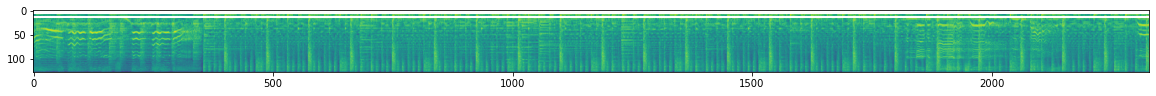

In [82]:
print(out1.shape)
plt.figure(figsize=(20,10))
plt.imshow(out2.log2().detach().numpy())

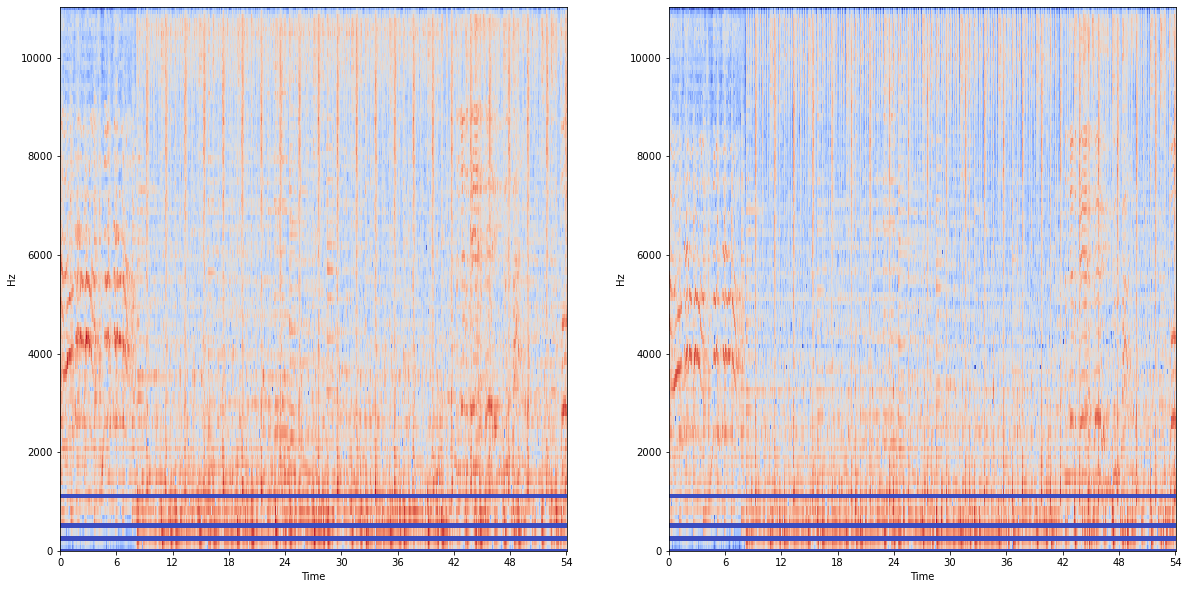

In [70]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
librosa.display.specshow(librosa.power_to_db(out1.numpy()), y_axis='linear', x_axis='time')

plt.subplot(1, 2, 2)
librosa.display.specshow(librosa.power_to_db(out2.numpy()), y_axis='linear', x_axis='time')

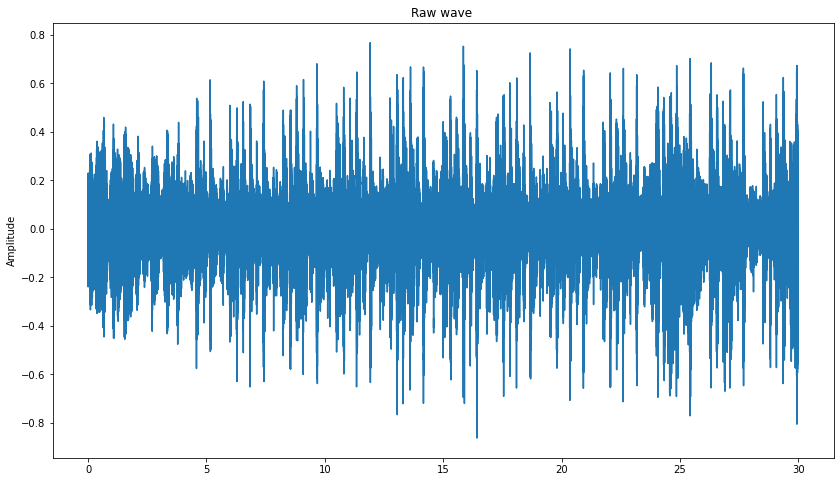

In [51]:
plot_time_series(first_item)

## Trying the CNN

In [16]:
# gtzan_waves
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter


ModuleNotFoundError: No module named 'tensorboard'

In [17]:
class CNN(nn.Module):
    def __init__(self, name, use_tensorboard=True):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)
        if use_tensorboard:
          self.train_summary_writer = SummaryWriter('logs/tensorboard/' + name + '/train')
          self.test_summary_writer = SummaryWriter('logs/tensorboard/' + name + '/test')

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)

        return x

In [24]:
class GtzanBetterDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __getitem__(self, index):
        return (self.transform(self.X[index]), self.y[index]) 
    def __len__(self):
        return len(self.X)
    def transform(self, x):
        x = torch.from_numpy(x).to(torch.float32)
        return aud_transforms.MelSpectrogram(16000)(x)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
in_channel = 1
num_classes = 10
learning_rate = 0.001
batch_size = 1
num_epochs = 5

In [27]:
from torch.utils.data import DataLoader

In [28]:
train_dataset = GtzanBetterDataset(gtzan_waves.train_x, gtzan_waves.train_y)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)

In [30]:
iterator = iter(train_loader)
el = iterator.next()

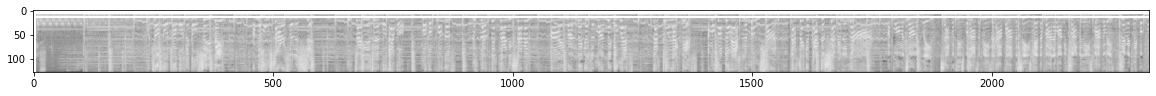

In [38]:
plt.figure(figsize=(20,10))
plt.imshow(el[0][0,:,:].detach().numpy(), cmap='gray')